# Lab 3
## Beamforming

# Part 1 
Here initially study narrowband beamforming and how investigate how different parameters influence the output of the beamformer. We build a class which will implement the beamformer to a narrowband signal which will be used as our base class in which we will be able to compare this against our later study in this lab. Our class assumes a Uniform Linear Array (ULA) with angles in radians and spacing in wavelengths.

In [130]:
import numpy as np
import matplotlib.pyplot as plt

In [131]:
class NarrowbandBeamformer:
    def __init__(self, n_elements, d=0.5, wavelength=1.0, window="rect"):
        self.N = n_elements
        self.d = d
        self.wavelength = wavelength
        self.k = 2*np.pi / self.wavelength
        self.n = np.arange(self.N)

        self.window = self._make_window(window)
        self.theta_steer = 0.0
        self.w = None
        self.steer_convent(self.theta_steer)

    def _make_window(self,window):
        if isinstance(window,str):
            wtype = window.lower()
            if wtype == "rect":
                w = np.ones(self.N)
            elif wtype == "hann":
                w = np.hanning(self.N)
            elif wtype == "hamming":
                w = np.hamming(self.N)
            else:
                raise ValueError(f"Unknown Window type")    
        else:
            w = np.asarray(window)
            if w.shape[0] != self.N:
                raise ValueError(f"Window must have the correct length")
        return w/np.max(np.abs(w))
    def update_weights(self):
        a = self.steering_vector(self.theta_steer)  
        self.w = self.window * a
    def steering_vector(self, theta):
        theta = np.asarray(theta)
        phase = self.k*self.d*np.outer(self.n, np.sin(theta))
        a = np.exp(1j*phase)
        if a.ndim == 2 and a.shape[1] == 1:
            a = a[:, 0]
        return a   
    def steer_convent(self, theta):
        self.theta_steer = theta
        self.update_weights()
    def beamform(self, X):
        X = np.asarray(X)
        if X.shape[0] == self.N:     
            return np.conj(self.w) @ X
        elif X.shape[-1] == self.N:  
            return X @ np.conj(self.w)
        else:
            raise ValueError(f"X must have N={self.N} as first or last dim, got {X.shape}")

    def beampattern(self, theta_grid):
        theta_grid = np.asarray(theta_grid)
        a = self.steering_vector(theta_grid)
        B = np.conj(self.w)@a
        P = np.abs(B)**2

        P/=np.max(P)
        P = 10*np.log10(np.maximum(P,1e-12))
        return P
    def doa_scan(self, X, theta_scan):
        X = np.asarray(X)
        theta_scan = np.asarray(theta_scan)
        metric = np.zeros_like(theta_scan)
        for i, th in enumerate(theta_scan):
            self.steer_convent(th)
            y = self.beamform(X)
            metric[i] = np.var(y)
        theta_hat = theta_scan[np.argmax(metric)]
        return theta_hat, metric
    






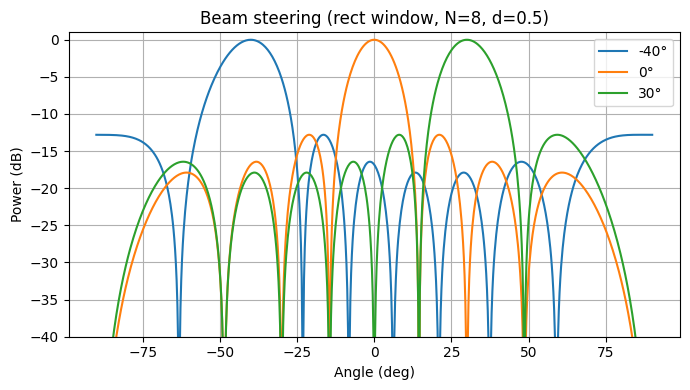

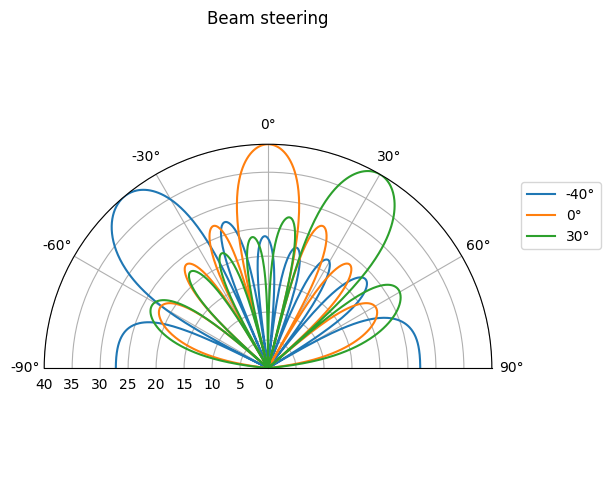

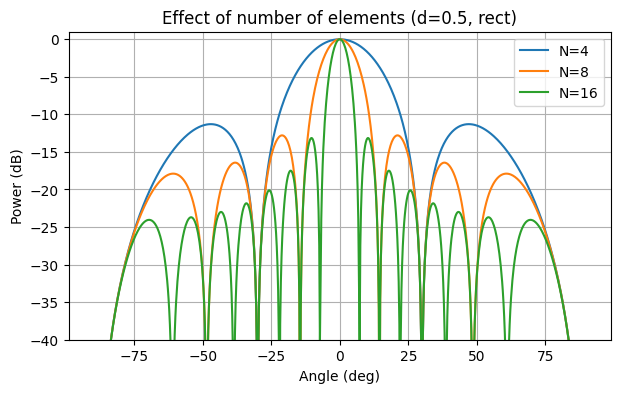

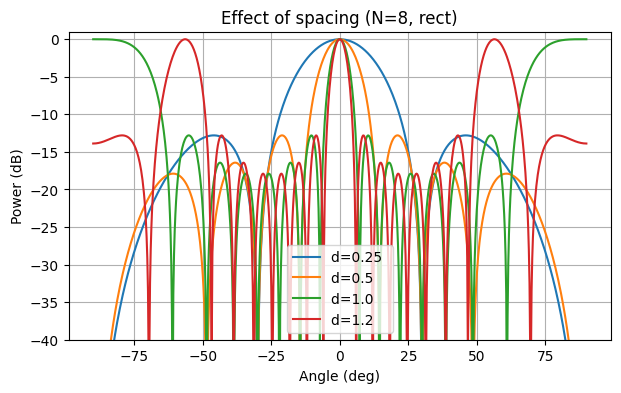

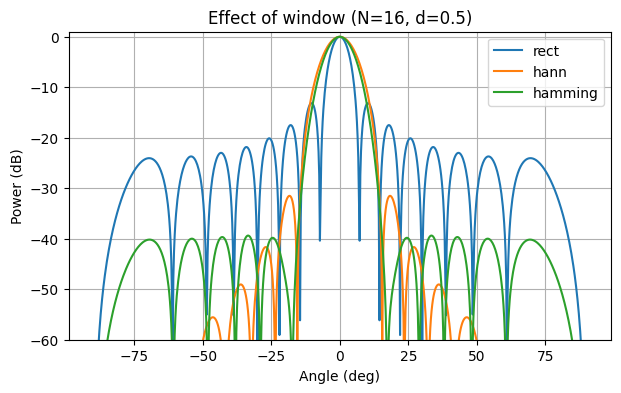

In [132]:

theta_grid = np.linspace(-np.pi/2, np.pi/2, 721)


bf = NarrowbandBeamformer(n_elements=8, d=0.5, window="rect")
steer_angles_deg = [-40, 0, 30]

plt.figure(figsize=(7, 4))
for th_deg in steer_angles_deg:
    bf.steer_convent(theta=np.deg2rad(th_deg))
    P = bf.beampattern(theta_grid) 
    plt.plot(np.rad2deg(theta_grid), P, label=f"{th_deg}°")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Beam steering (rect window, N=8, d=0.5)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()
plt.tight_layout()

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 5))
for th_deg in steer_angles_deg:
    bf.steer_convent(theta=np.deg2rad(th_deg))
    P = bf.beampattern(theta_grid)  
    P_clip = np.clip(P, -40, 0)
    r = P_clip + 40
    ax.plot(theta_grid, r, label=f"{th_deg}°")

ax.set_theta_zero_location("N")   
ax.set_theta_direction(-1)     
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_rmax(40)
ax.set_title("Beam steering")

ax.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()


plt.figure(figsize=(7, 4))
for N in [4, 8, 16]:
    bfN = NarrowbandBeamformer(n_elements=N, d=0.5, window="rect")
    bfN.steer_convent(theta=0.0)  
    P = bfN.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=f"N={N}")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of number of elements (d=0.5, rect)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()


plt.figure(figsize=(7, 4))
for d in [0.25, 0.5, 1.0, 1.2]:
    bf_d = NarrowbandBeamformer(n_elements=8, d=d, window="rect")
    bf_d.steer_convent(theta=0.0)
    P = bf_d.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=f"d={d} ")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of spacing (N=8, rect)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()

plt.figure(figsize=(7, 4))
windows = ["rect", "hann", "hamming"]
for win in windows:
    bf_w = NarrowbandBeamformer(n_elements=16, d=0.5, window=win)
    bf_w.steer_convent(theta=0.0)
    P = bf_w.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=win)
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of window (N=16, d=0.5)")
plt.ylim([-60, 1])
plt.grid(True)
plt.legend()

plt.show()

In [133]:
def simulate_narrowband_ula(N, d, theta_deg, n_samples=2000, snr_dB=10, wavelength=1.0, f0=0.05):
    bf = NarrowbandBeamformer(n_elements=N, d=d, wavelength=wavelength)
    theta = np.deg2rad(theta_deg)
    a = bf.steering_vector(theta)

    t = np.arange(n_samples)
    s = np.exp(1j * 2 * np.pi * f0 * t)

    X_sig = a[:, None] * s[None, :]

    snr_linear = 10**(snr_dB / 10)
    signal_power = 1.0
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (
        np.random.randn(*X_sig.shape) + 1j*np.random.randn(*X_sig.shape)
    )
    return X_sig + noise

In [134]:
def simulate_narrowband_ula_simple(N, d, theta_deg, n_samples=2000,
                                   noise_std=0.5, wavelength=1.0, f0=0.05):
    bf = NarrowbandBeamformer(n_elements=N, d=d, wavelength=wavelength)
    theta = np.deg2rad(theta_deg)
    a = bf.steering_vector(theta)

    t = np.arange(n_samples)
    s = np.exp(1j * 2 * np.pi * f0 * t)

    X_sig = a[:, None] * s[None, :]

    n = np.random.randn(*X_sig.shape) + 1j*np.random.randn(*X_sig.shape)
    X = X_sig + noise_std * n
    return X

True DOA: 20 deg
Estimated DOA: 20.00 deg


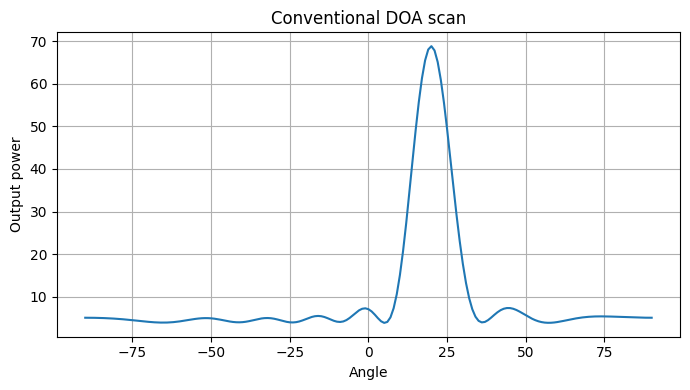

In [135]:
N = 8
d = 0.5
theta_true_deg = 20

X = simulate_narrowband_ula_simple(N=N, d=d, theta_deg=theta_true_deg,
                            )

bf = NarrowbandBeamformer(n_elements=N, d=d, window="rect")

theta_scan = np.linspace(-np.pi/2, np.pi/2, 181) 
theta_hat, metric = bf.doa_scan(X, theta_scan)

print(f"True DOA: {theta_true_deg} deg")
print(f"Estimated DOA: {np.rad2deg(theta_hat):.2f} deg")

plt.figure(figsize=(7, 4))
plt.plot(np.rad2deg(theta_scan), metric)
plt.xlabel("Angle")
plt.ylabel("Output power")
plt.title("Conventional DOA scan")
plt.grid(True)
plt.tight_layout()
plt.show()

In [136]:
class MVDRBeamformer(NarrowbandBeamformer):

    def __init__(self, n_elements, d=0.5, wavelength=1.0, window="rect"):
        super().__init__(n_elements, d=d, wavelength=wavelength, window=window)
        self.R = None 

    def estimate_covariance(self, X):
        X = np.asarray(X)
        self.R = (X @ X.conj().T) / X.shape[1]

    def steer_mvdr(self, theta):

        a_theta = self.steering_vector(theta).reshape(-1, 1) 
        term1 = np.linalg.solve(self.R, a_theta)   
        term2 = a_theta.conj().T @ term1         

        w_mvdr = term1 / term2                       
        self.w = w_mvdr.flatten()              
        self.theta_steer = theta

In [137]:

def simulate_two_source_ula_simple(
    N,
    d,
    theta_des_deg,
    theta_int_deg,
    n_samples=2000,         
    noise_std=0.05,      
    f_des=0.05,          
    f_int=0.07           
):

    n = np.arange(N)
    theta_des = np.deg2rad(theta_des_deg)
    theta_int = np.deg2rad(theta_int_deg)
    s_des = np.exp(2j * np.pi * d * n * np.sin(theta_des)).reshape(-1, 1)  
    s_int = np.exp(2j * np.pi * d * n * np.sin(theta_int)).reshape(-1, 1)  
    t = np.arange(n_samples)
    tone_des = np.exp(2j * np.pi * f_des * t).reshape(1, -1) 
    tone_int = np.exp(2j * np.pi * f_int * t).reshape(1, -1) 

    X_des = s_des @ tone_des  
    X_int =  s_int @ tone_int
    noise = (np.random.randn(N, n_samples) +
             1j * np.random.randn(N, n_samples))

    X = X_des + X_int + noise_std * noise
    return X

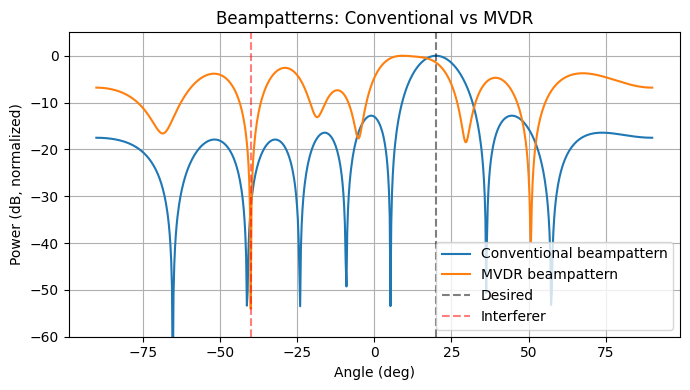

In [138]:

N = 8
d = 0.5
theta_des_deg = 20  
theta_int_deg = -40   

X = simulate_two_source_ula_simple(
    N=N,
    d=d,
    theta_des_deg=theta_des_deg,
    theta_int_deg=theta_int_deg,
    n_samples=2000,
    noise_std=0.05,
    f_des=0.02,
    f_int=0.06
)

theta_grid = np.linspace(-np.pi/2, np.pi/2, 721)

bf = NarrowbandBeamformer(n_elements=N, d=d, window="rect")
theta0 = np.deg2rad(theta_des_deg)
bf.steer_convent(theta0)
P_conv_bp = bf.beampattern(theta_grid)     

mvdr = MVDRBeamformer(n_elements=N, d=d)
mvdr.estimate_covariance(X)            
mvdr.steer_mvdr(theta0)                  
P_mvdr_bp = mvdr.beampattern(theta_grid)    
plt.figure(figsize=(7, 4))
plt.plot(np.rad2deg(theta_grid), P_conv_bp, label="Conventional beampattern")
plt.plot(np.rad2deg(theta_grid), P_mvdr_bp, label="MVDR beampattern")
plt.axvline(theta_des_deg, color="k", linestyle="--", alpha=0.5, label="Desired")
plt.axvline(theta_int_deg, color="r", linestyle="--", alpha=0.5, label="Interferer")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB, normalized)")
plt.title("Beampatterns: Conventional vs MVDR")
plt.ylim([-60, 5])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

    